# Sonar data

About Dataset

Context:

Dataset is collection of sonar data. Which Predict weather we have found rock or mine

Content:

It contains various data column which consist sonar data. Last column tells us weather it has found rock or mine.

Target Column consist of :

R - > Rock

M -> Mine

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA, TruncatedSVD

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

Зададим размер тестовой выборки, сид, число фолдов и метрику оценки

In [3]:
TEST_SIZE = 0.2
SEED = 1000
num_folds = 5
scoring = 'accuracy'

In [4]:
df = pd.read_csv("sonar_data.csv", header=None)

le = LabelEncoder()
df[df.columns[-1]] = le.fit_transform(df[df.columns[-1]].values) #1-R 0-M

In [5]:
df.columns = [f"F{i}" for i in range(60)] + ["Target"]
df.head()

,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F51,F52,F53,F54,F55,F56,F57,F58,F59,Target
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,1
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,1
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,1
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,1
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,1


<Axes: >

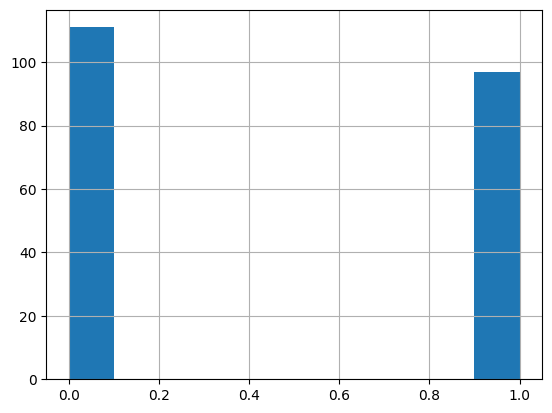

In [9]:
df.Target.hist()

Классы сбалансированы

In [11]:
col = df.columns

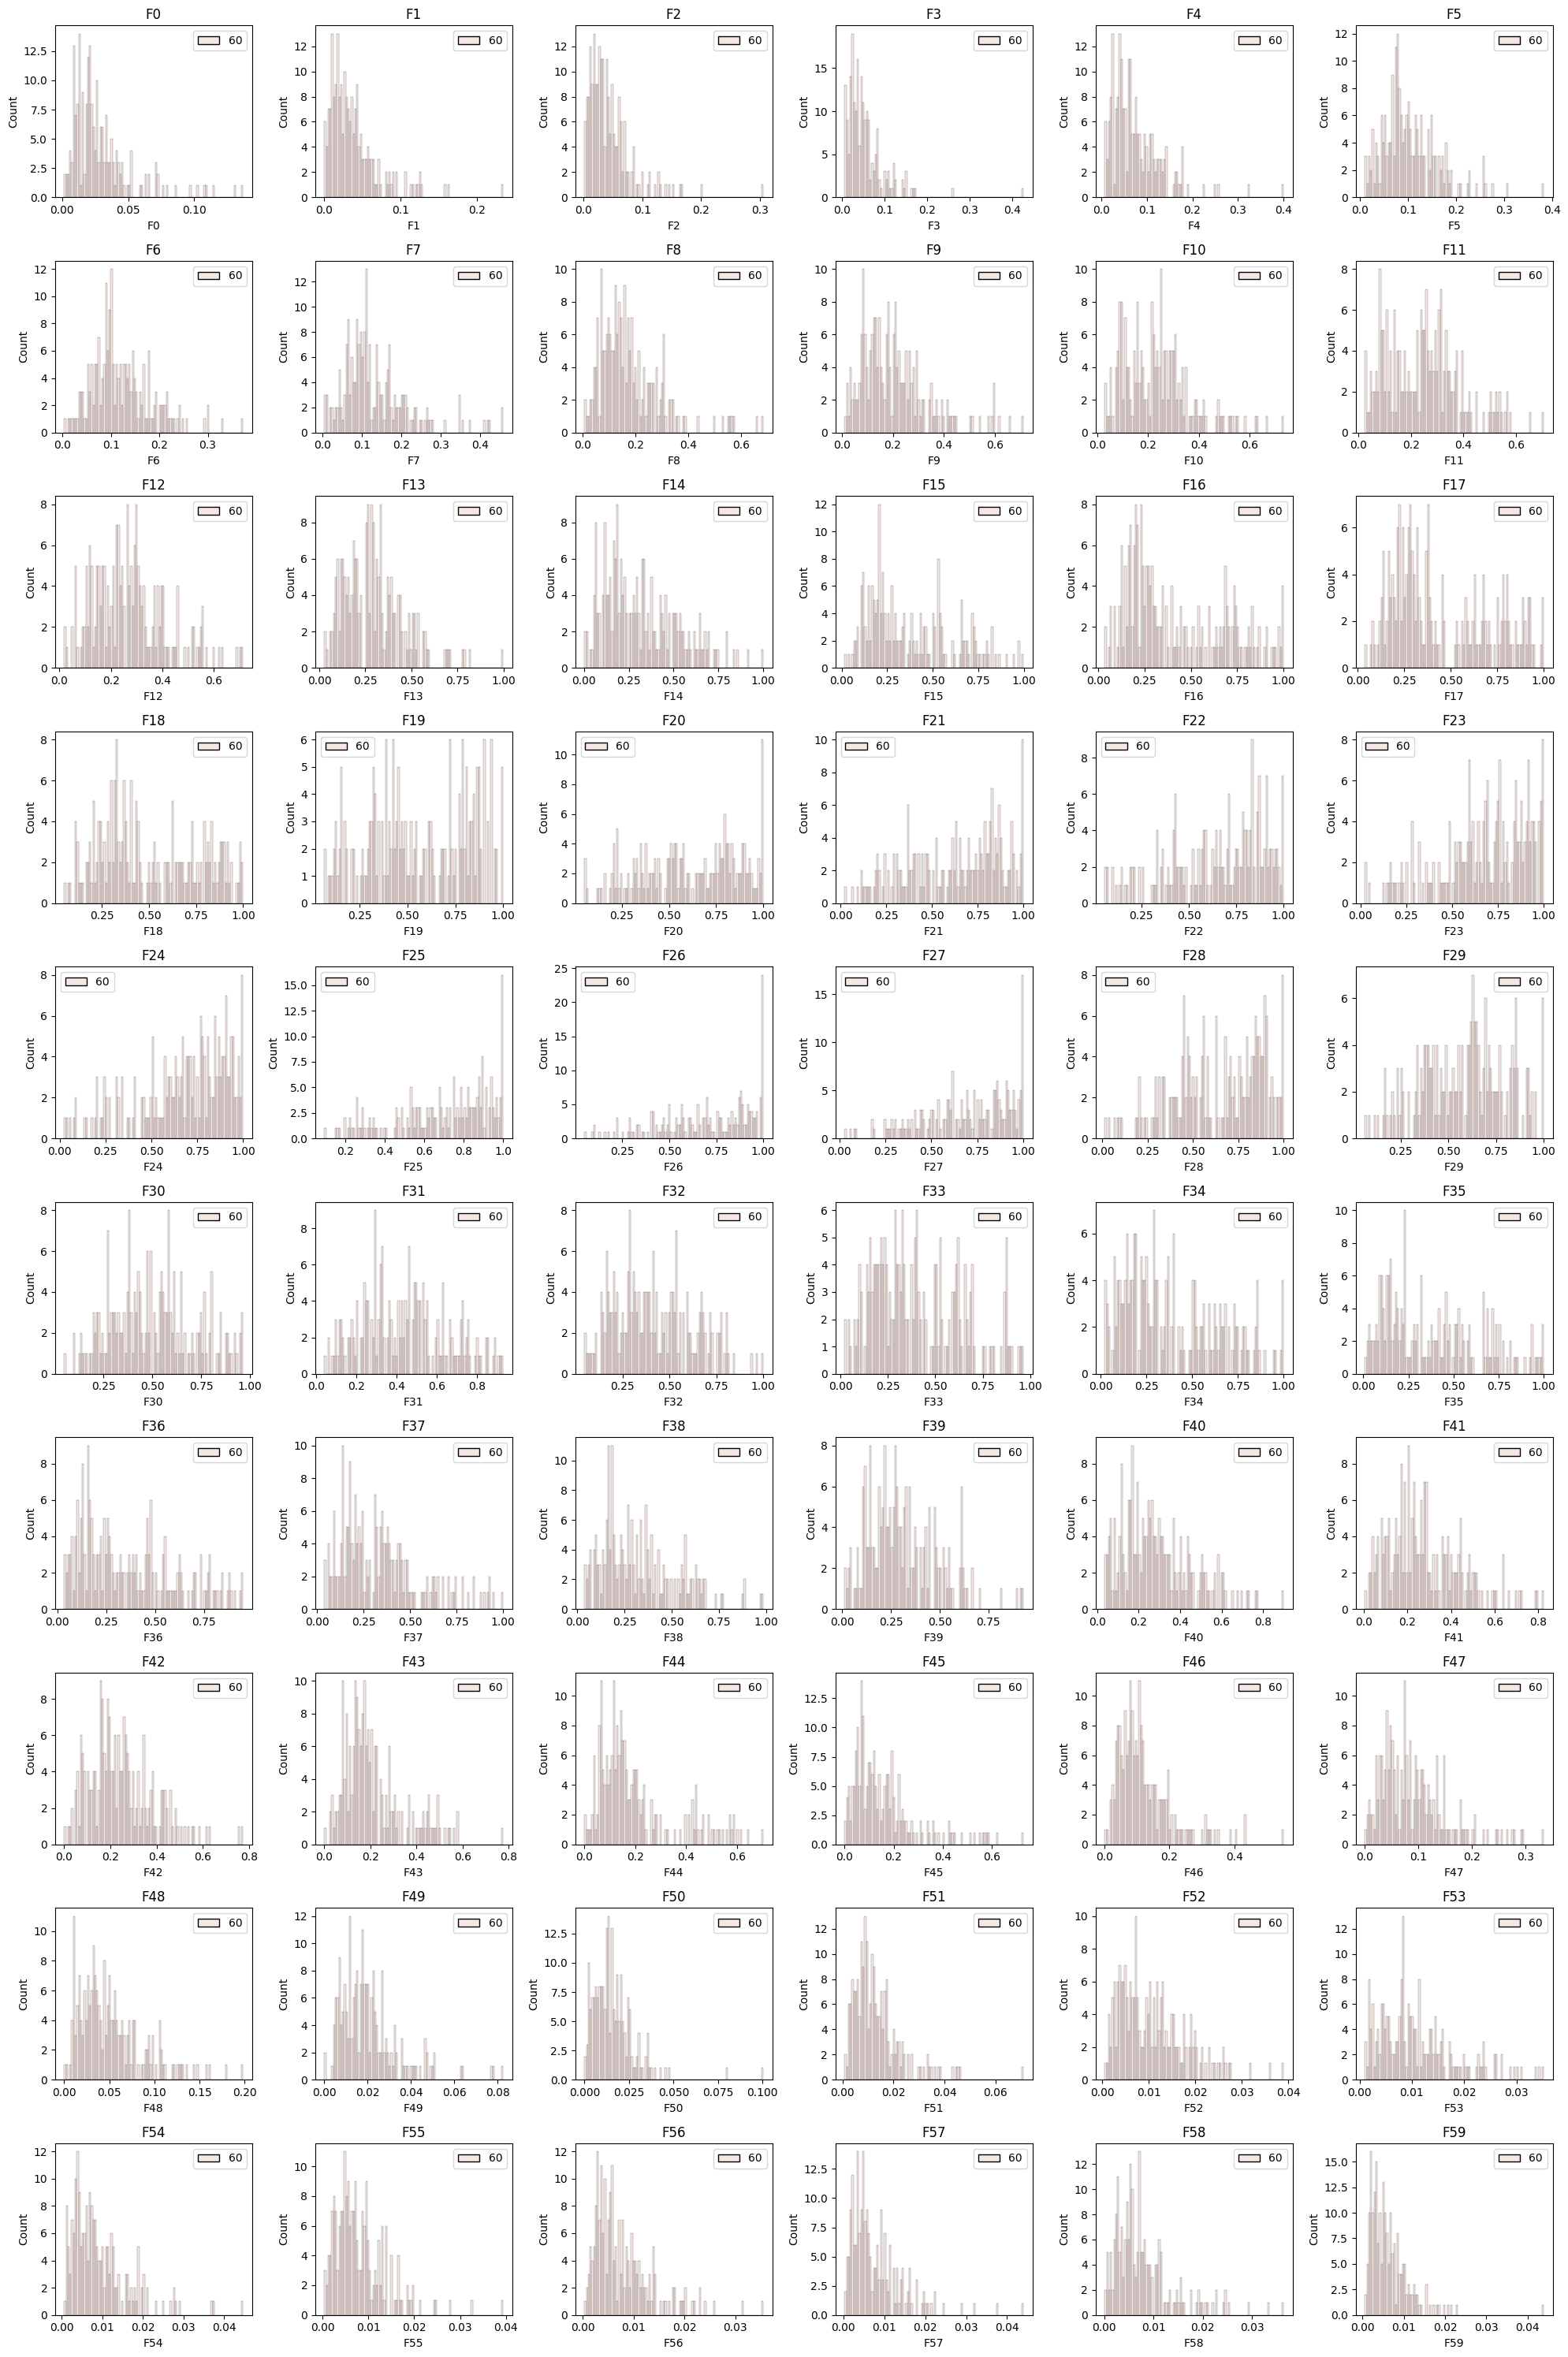

In [5]:
fig = plt.figure(figsize=(20,30))

for i in range(len(col) - 1):
    plt.subplot(10, 6, i + 1)
    plt.title(col[i])
    sns.histplot(data=df, x=df[col[i]], hue=60, bins=100)

plt.tight_layout()

<Figure size 2000x3000 with 0 Axes>

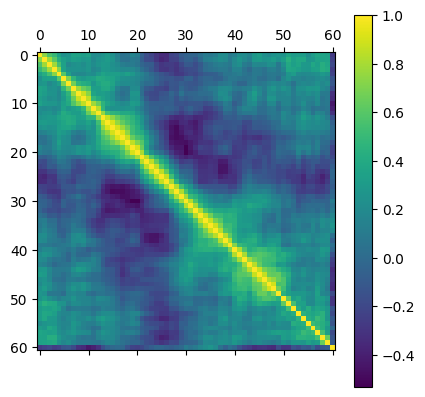

In [7]:
fig = plt.figure(figsize=(20,30))

plt.matshow(df.corr())
cb = plt.colorbar()
plt.show()

In [12]:
X = df[df.columns[:60]]
y = df[df.columns[-1]]

In [13]:
scaler = StandardScaler()
normalizer = RobustScaler(quantile_range=(0.05, 0.95))
pipe = Pipeline([('normalizer', normalizer),
                 ('scaler', scaler)])

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

In [15]:
x_train_norm = pipe.fit_transform(x_train)
x_test_norm = pipe.transform(x_test)

x_norm = pipe.transform(X)

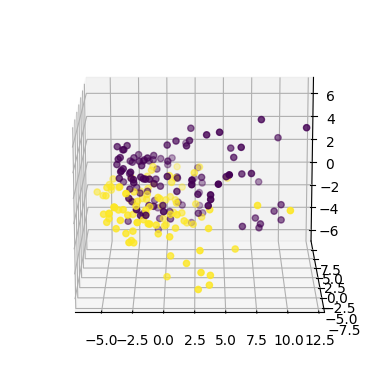

In [16]:
svd = PCA(n_components=3)
svd.fit(x_norm)
x_trunc_norm_3 = svd.transform(x_norm)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x_trunc_norm_3[:, 0], x_trunc_norm_3[:, 1], x_trunc_norm_3[:, 2], c=y, s=20);
ax.view_init(15, 270)

Визуально можно кластеризовать, даже приблизительно линейно - значит, линейные модели могут сработать неплохо

## Model selection

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, BaggingClassifier

In [310]:
def get_pipeline(clf, n_components=10):
    pipeline = Pipeline([
        ('normalizer', normalizer),
        ('scaler', scaler),
        ('pca', PCA(n_components=n_components, random_state=SEED)),
        ('clf', clf)
    ])
    return pipeline

In [337]:
models = []
models.append(('NB', GaussianNB()))
models.append(('LR', LogisticRegression()))
models.append(('SVC_poly', SVC(kernel='poly', degree=3, coef0=0.26, C=500)))
models.append(('SVC_rbf', SVC(kernel='rbf', C=500, gamma='auto')))
models.append(('mlp', MLPClassifier(hidden_layer_sizes=180, max_iter=1000000, random_state=SEED, )))
models.append(('forest', RandomForestClassifier(n_estimators=32, )))
models.append(('tree', DecisionTreeClassifier(max_depth=29)))
# models.append(('stacking', StackingClassifier(models, final_estimator=DecisionTreeClassifier())))
# models.append(('bagging', BaggingClassifier(estimator=SVC(C=1000), n_jobs=-1, random_state=SEED, n_estimators=8)))

results = []
kfold = KFold(n_splits=num_folds, random_state=SEED, shuffle=True)
names = []
cur_max = 0
for name, clf in models:
    pipeline = get_pipeline(clf, n_components=36)
    cv_results = cross_val_score(pipeline, X, y, cv=kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "Model %s:   mean: %f   std: %f" % (name, cv_results.mean(), cv_results.std())
    
    if cv_results.mean() > cur_max:
        best_model = pipeline
        cur_max = cv_results.mean()
    
    print(msg)

Model NB:   mean: 0.726597   std: 0.062878
Model LR:   mean: 0.745180   std: 0.058120
Model SVC_poly:   mean: 0.879791   std: 0.030151
Model SVC_rbf:   mean: 0.889547   std: 0.055406
Model mlp:   mean: 0.841812   std: 0.071826
Model forest:   mean: 0.802787   std: 0.042214
Model tree:   mean: 0.783391   std: 0.061576


## P.S.

In [345]:
pca = PCA(n_components=30, random_state=20)
pca.fit(x_train_norm)
clf = SVC(kernel='rbf', C=10, gamma='auto')
x_train_trunc = pca.transform(x_train_norm)
x_test_trunc = pca.transform(x_test_norm)
clf.fit(x_train_trunc, y_train)

SVC(C=10, gamma='auto')

In [347]:
accuracy_score(clf.predict(x_test_trunc), y_test)

0.9285714285714286

In [24]:
#import catboost
#clf = catboost.CatBoostClassifier()
#clf.fit(x_train, y_train)
#accuracy_score(clf.predict(x_test), y_test)